In [2]:
from IPython.core.debugger import set_trace

%load_ext nb_black

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import time

plt.style.use(style="seaborn")
%matplotlib inline

<IPython.core.display.Javascript object>

In [3]:
df = pd.read_csv("BTC-USD.csv")

<IPython.core.display.Javascript object>

In [35]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800.0
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200.0
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700.0
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600.0
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2386 entries, 0 to 2385
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       2386 non-null   object 
 1   Open       2382 non-null   float64
 2   High       2382 non-null   float64
 3   Low        2382 non-null   float64
 4   Close      2382 non-null   float64
 5   Adj Close  2382 non-null   float64
 6   Volume     2382 non-null   float64
dtypes: float64(6), object(1)
memory usage: 130.6+ KB


<IPython.core.display.Javascript object>

In [5]:
df.set_index("Date", drop=True, inplace=True)

<IPython.core.display.Javascript object>

Use only the close feature

In [6]:
df = df[["Close"]]

<IPython.core.display.Javascript object>

In [8]:
type(df["Close"]) == type(df[["Close"]])

False

<IPython.core.display.Javascript object>

In [9]:
type(df[["Close"]])

pandas.core.frame.DataFrame

<IPython.core.display.Javascript object>

In [10]:
df.describe()

,Close
count,2382.000000
mean,6404.846907
std,9100.984821
min,178.102997
25%,454.276993
50%,4072.225098
75%,8843.898926
max,61243.085938


<IPython.core.display.Javascript object>

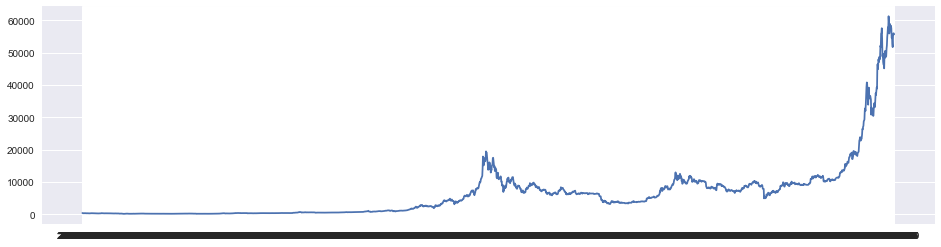

<IPython.core.display.Javascript object>

In [11]:
plt.figure(1, figsize=(16,4))
_ = plt.plot(df.Close)

Text(0, 0.5, 'Close Price (USD)')

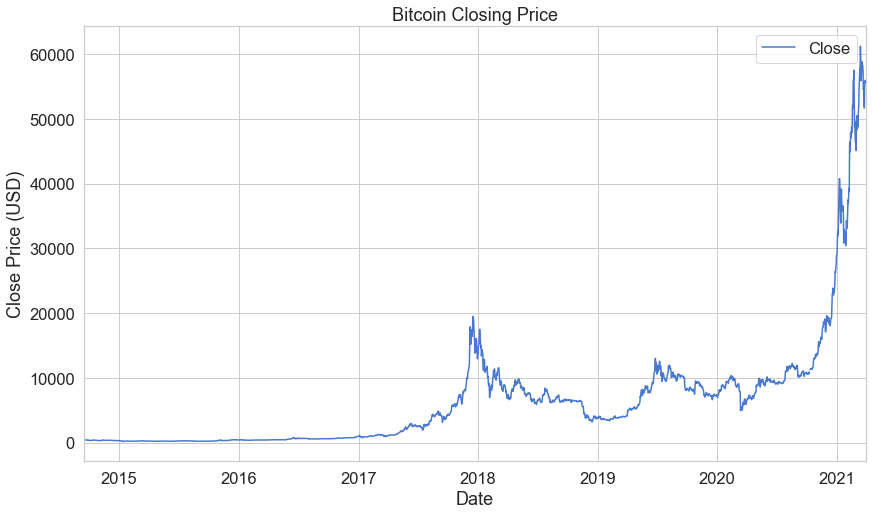

In [37]:
ax = df.plot(x='Date', y='Close');
ax.set_title("Bitcoin Closing Price")
ax.set_xlabel("Date")
ax.set_ylabel("Close Price (USD)")

In [38]:
scaler = MinMaxScaler()
close_price = df.Close.values.reshape(-1, 1)
scaled_close = scaler.fit_transform(close_price)

In [39]:
scaled_close.shape

(2386, 1)

In [40]:
scaled_close

array([[0.00457269],
       [0.00403401],
       [0.00354856],
       ...,
       [0.91370547],
       [0.91333266],
       [0.90837693]])

In [41]:
np.isnan(scaled_close).any()

True

In [42]:
scaled_close = scaled_close[~np.isnan(scaled_close)]

In [43]:
scaled_close = scaled_close.reshape(-1, 1)

In [44]:
np.isnan(scaled_close).any()

False

In [45]:
SEQ_LEN = 100
def to_sequences(data, seq_len):
    d = []
    for index in range(len(data) - seq_len):
        d.append(data[index: index + seq_len])
    return np.array(d)

def preprocess(data_raw, seq_len, train_split):
    data = to_sequences(data_raw, seq_len)
    num_train = int(train_split * data.shape[0])

    X_train = data[:num_train, :-1, :]
    Y_train = data[:num_train, -1:, :]

    X_test = data[num_train:, :-1, :]
    Y_test = data[num_train:, -1:, :]

    return X_train, Y_train, X_test, Y_test

In [46]:
X_train, Y_train, X_test, Y_test = preprocess(scaled_close, SEQ_LEN, train_split=0.7)

In [47]:
print(X_train.shape)
print(X_test.shape)

(1597, 99, 1)
(685, 99, 1)


In [49]:
DROPOUT = 0.2
WINDOW_SIZE = SEQ_LEN - 1

model = keras.Sequential()

model.add(Bidirectional(LSTM(WINDOW_SIZE, return_sequences=True),
                        input_shape=(WINDOW_SIZE, X_train.shape[-1])))
model.add(Dropout(rate=DROPOUT))

model.add(Bidirectional(LSTM((WINDOW_SIZE * 2), return_sequences=True)))
model.add(Dropout(rate=DROPOUT))

model.add(Bidirectional(LSTM(WINDOW_SIZE, return_sequences=False)))

model.add(Dense(units=1))

model.add(Activation('linear'))

In [50]:
model.compile(
    loss='mean_squared_error', 
    optimizer='adam'
)

In [52]:
BATCH_SIZE = 64

history = model.fit(
    X_train, 
    Y_train, 
    epochs=100, 
    batch_size=BATCH_SIZE, 
    shuffle=False,
    validation_split=0.1
)

Epoch 1/100
23/23 [==============================] - 34s 1s/step - loss: 0.0020 - val_loss: 3.0812e-04
Epoch 2/100
23/23 [==============================] - 25s 1s/step - loss: 0.0028 - val_loss: 9.5531e-04
Epoch 3/100
23/23 [==============================] - 29s 1s/step - loss: 0.0030 - val_loss: 0.0047
Epoch 4/100
23/23 [==============================] - 29s 1s/step - loss: 0.0032 - val_loss: 0.0058
Epoch 5/100
23/23 [==============================] - 32s 1s/step - loss: 0.0031 - val_loss: 0.0058
Epoch 6/100
23/23 [==============================] - 30s 1s/step - loss: 0.0029 - val_loss: 0.0036
Epoch 7/100
23/23 [==============================] - 31s 1s/step - loss: 0.0015 - val_loss: 0.0012
Epoch 8/100
23/23 [==============================] - 30s 1s/step - loss: 0.0011 - val_loss: 5.2620e-05
Epoch 9/100
23/23 [==============================] - 32s 1s/step - loss: 8.7649e-04 - val_loss: 3.7149e-04
Epoch 10/100
23/23 [==============================] - 36s 2s/step - loss: 0.0016 - val_lo

In [53]:
model.evaluate(X_test, Y_test)

22/22 [==============================] - 4s 198ms/step - loss: 0.0036


0.0035994448699057102

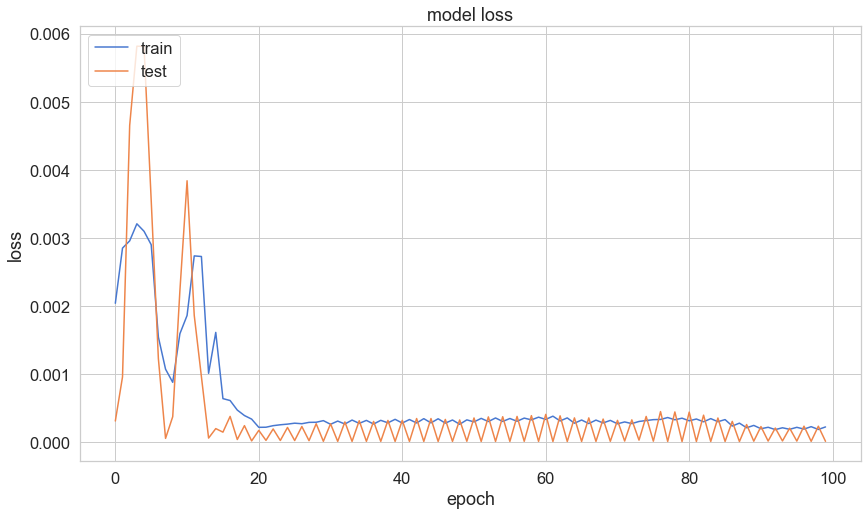

In [54]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [59]:
Y_hat = model.predict(X_test)

Y_test_inverse = scaler.inverse_transform(Y_test)
Y_hat_inverse = scaler.inverse_transform(Y_hat)
 
plt.plot(Y_test_inverse, label="Actual Price", color='green')
plt.plot(Y_hat_inverse, label="Predicted Price", color='red')
 
plt.title('Bitcoin price prediction')
plt.xlabel('Time [days]')
plt.ylabel('Price')
plt.legend(loc='best')
 
plt.show()

ValueError: Found array with dim 3. Estimator expected <= 2.